🚀 Generating Overlap Samples...


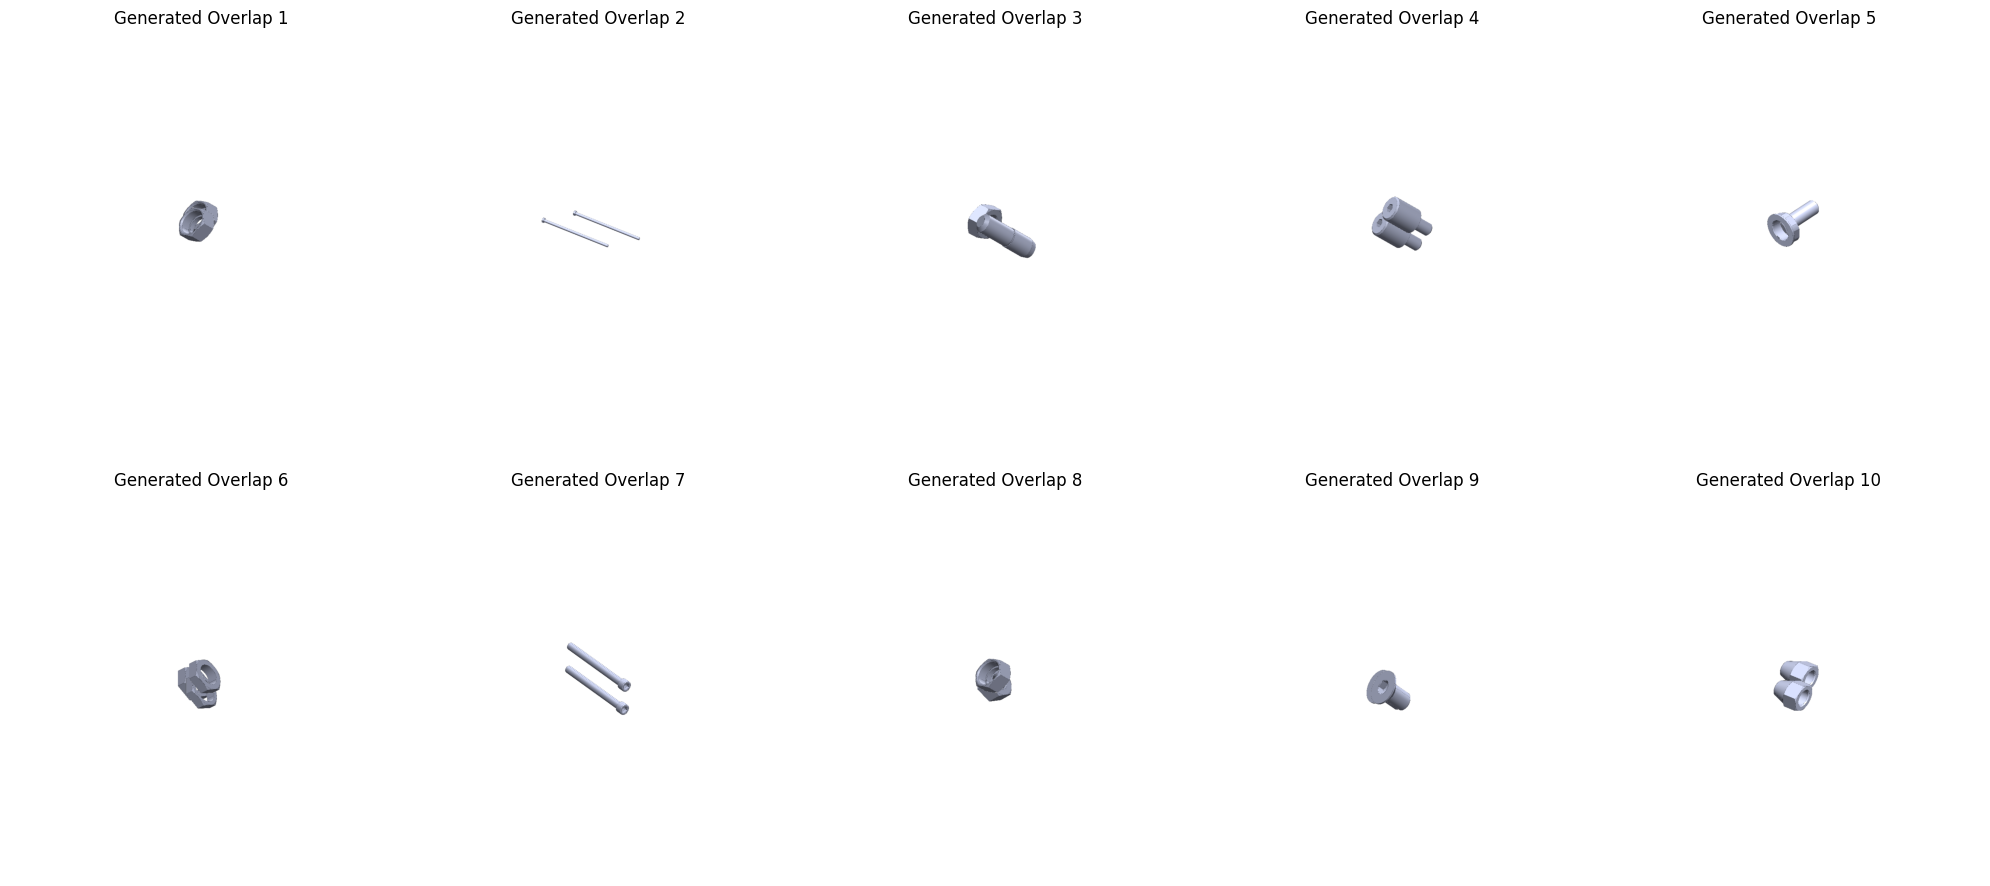

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

BASE_DIR = '/kaggle/input/solidworks-ai-hackathon'
IMG_DIR = os.path.join(BASE_DIR, 'train', 'train')
LABEL_FILE = os.path.join(BASE_DIR, 'train_labels.csv')

def get_objects_from_image(img_path):
    """Reads an image and extracts individual objects using contours."""
    img = cv2.imread(img_path)
    if img is None: return []
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    extracted_objects = []
    for cnt in contours:
        if cv2.contourArea(cnt) > 500:
            x, y, w, h = cv2.boundingRect(cnt)
            
            obj = img[y:y+h, x:x+w]
            

            obj_gray = cv2.cvtColor(obj, cv2.COLOR_BGR2GRAY)
            _, mask = cv2.threshold(obj_gray, 240, 255, cv2.THRESH_BINARY_INV)
            
            extracted_objects.append((obj, mask))
            
    return extracted_objects

def create_overlap_image(objects_pool):
    """Creates a new image with overlapping objects from the pool."""
    if not objects_pool: return None
    
 
    canvas = np.ones((1024, 1024, 3), dtype=np.uint8) * 255
    
    
    num_to_paste = 2 if random.random() < 0.90 else 3
    
    selected_objects = random.choices(objects_pool, k=num_to_paste)
    
    center_x, center_y = 512, 512
    
    for i, (obj, mask) in enumerate(selected_objects):
        h, w = obj.shape[:2]
        

        shift_x = random.randint(-int(w * 0.4), int(w * 0.4))
        shift_y = random.randint(-int(h * 0.4), int(h * 0.4))
        
        x_pos = max(0, min(1024 - w, center_x - w//2 + shift_x))
        y_pos = max(0, min(1024 - h, center_y - h//2 + shift_y))

        roi = canvas[y_pos:y_pos+h, x_pos:x_pos+w]
        

        mask_inv = cv2.bitwise_not(mask)
        img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
        

        img_fg = cv2.bitwise_and(obj, obj, mask=mask)
        
       
        dst = cv2.add(img_bg, img_fg)
        canvas[y_pos:y_pos+h, x_pos:x_pos+w] = dst

    return canvas


df = pd.read_csv(LABEL_FILE).sample(10, random_state=42) 
print("🚀 Generating Overlap Samples...")

plt.figure(figsize=(20, 10))

for i, (idx, row) in enumerate(df.iterrows()):

    img_path = os.path.join(IMG_DIR, row['image_name'])
    objects = get_objects_from_image(img_path)
    
    if len(objects) > 0:
   
        new_img = create_overlap_image(objects)
        

        plt.subplot(2, 5, i+1)
        plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Generated Overlap {i+1}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [2]:
import cv2
import numpy as np
import pandas as pd
import os
import random
from tqdm import tqdm


BASE_DIR = '/kaggle/input/solidworks-ai-hackathon'
IMG_DIR = os.path.join(BASE_DIR, 'train', 'train')
LABEL_FILE = os.path.join(BASE_DIR, 'train_labels.csv')


SYNTH_DIR = 'train_synthetic'
SYNTH_CSV = 'synthetic_labels.csv'
os.makedirs(SYNTH_DIR, exist_ok=True)



print("📦 Building Object Library from Single-Item Images...")
df = pd.read_csv(LABEL_FILE)
df['total'] = df[['bolt', 'locatingpin', 'nut', 'washer']].sum(axis=1)
single_item_df = df[df['total'] == 1]

object_library = {
    'bolt': [], 'locatingpin': [], 'nut': [], 'washer': []
}

def extract_largest_object(img_path):
    img = cv2.imread(img_path)
    if img is None: return None
    

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours: return None
    
    c = max(contours, key=cv2.contourArea)
    if cv2.contourArea(c) < 500: return None 
    
    x, y, w, h = cv2.boundingRect(c)
    
    # Crop and Mask
    obj_crop = img[y:y+h, x:x+w]
    obj_gray = cv2.cvtColor(obj_crop, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(obj_gray, 240, 255, cv2.THRESH_BINARY_INV)
    
    return obj_crop, mask

counts = {'bolt': 0, 'locatingpin': 0, 'nut': 0, 'washer': 0}

for idx, row in tqdm(single_item_df.iterrows(), total=len(single_item_df), desc="Extracting"):

    part_type = None
    for col in ['bolt', 'locatingpin', 'nut', 'washer']:
        if row[col] == 1:
            part_type = col
            break
            
    if counts[part_type] >= 500: continue
    
    img_path = os.path.join(IMG_DIR, row['image_name'])
    result = extract_largest_object(img_path)
    
    if result:
        object_library[part_type].append(result)
        counts[part_type] += 1

print(f"✅ Library Built: {counts}")



NUM_IMAGES_TO_GENERATE = 2000  
new_rows = []

print(f"🚀 Generating {NUM_IMAGES_TO_GENERATE} Synthetic Images...")

for i in tqdm(range(NUM_IMAGES_TO_GENERATE), desc="Synthesizing"):

    canvas = np.ones((1024, 1024, 3), dtype=np.uint8) * 255
    num_items = random.randint(2, 4)
    current_counts = {'bolt': 0, 'locatingpin': 0, 'nut': 0, 'washer': 0}
    

    items_to_paste = []
    for _ in range(num_items):
        p_type = random.choice(['bolt', 'locatingpin', 'nut', 'washer'])
        if not object_library[p_type]: continue # Skip if empty
        
        obj, mask = random.choice(object_library[p_type])
        items_to_paste.append((obj, mask))
        current_counts[p_type] += 1
        

    center_x, center_y = 512, 512
    
    for obj, mask in items_to_paste:
        h, w = obj.shape[:2]
        
        shift_x = random.randint(-200, 200)
        shift_y = random.randint(-200, 200)
        
        x_pos = max(0, min(1024 - w, center_x - w//2 + shift_x))
        y_pos = max(0, min(1024 - h, center_y - h//2 + shift_y))
        
        roi = canvas[y_pos:y_pos+h, x_pos:x_pos+w]
        
        mask_inv = cv2.bitwise_not(mask)
        img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
        img_fg = cv2.bitwise_and(obj, obj, mask=mask)
        
        dst = cv2.add(img_bg, img_fg)
        canvas[y_pos:y_pos+h, x_pos:x_pos+w] = dst
        
    file_name = f"synth_{i:05d}.png"
    cv2.imwrite(os.path.join(SYNTH_DIR, file_name), canvas)
    
    row_data = {
        'image_name': file_name,
        'bolt': current_counts['bolt'],
        'locatingpin': current_counts['locatingpin'],
        'nut': current_counts['nut'],
        'washer': current_counts['washer']
    }
    new_rows.append(row_data)

synth_df = pd.DataFrame(new_rows)
synth_df.to_csv(SYNTH_CSV, index=False)

print("\n🎉 DONE!")
print(f"📁 Images saved to: {SYNTH_DIR}")
print(f"📄 CSV saved to: {SYNTH_CSV}")
print(synth_df.head())

📦 Building Object Library from Single-Item Images...


Extracting: 100%|██████████| 2521/2521 [00:37<00:00, 66.75it/s] 


✅ Library Built: {'bolt': 500, 'locatingpin': 500, 'nut': 500, 'washer': 500}
🚀 Generating 2000 Synthetic Images...


Synthesizing: 100%|██████████| 2000/2000 [00:26<00:00, 75.13it/s]


🎉 DONE!
📁 Images saved to: train_synthetic
📄 CSV saved to: synthetic_labels.csv
        image_name  bolt  locatingpin  nut  washer
0  synth_00000.png     0            1    1       1
1  synth_00001.png     0            2    0       0
2  synth_00002.png     1            1    1       1
3  synth_00003.png     1            1    0       0
4  synth_00004.png     2            0    0       0


In [3]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

ORIGINAL_CSV = '/kaggle/input/solidworks-ai-hackathon/train_labels.csv'
ORIGINAL_IMG_DIR = '/kaggle/input/solidworks-ai-hackathon/train/train'

SYNTH_CSV = '/kaggle/working/synthetic_labels.csv'
SYNTH_IMG_DIR = '/kaggle/working/train_synthetic'

df_orig = pd.read_csv(ORIGINAL_CSV)
df_orig['file_path'] = df_orig['image_name'].apply(lambda x: os.path.join(ORIGINAL_IMG_DIR, x))

df_synth = pd.read_csv(SYNTH_CSV)
df_synth['file_path'] = df_synth['image_name'].apply(lambda x: os.path.join(SYNTH_IMG_DIR, x))

full_df = pd.concat([df_orig, df_synth], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✅ Merged! Total Images: {len(full_df)}")
print(f"   - Original: {len(df_orig)}")
print(f"   - Synthetic: {len(df_synth)}")

train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42)

✅ Merged! Total Images: 12000
   - Original: 10000
   - Synthetic: 2000


In [5]:
import os
import sys
import time
import random
import cv2
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm

class Config:
    # INPUT PATHS
    ORIGINAL_CSV = '/kaggle/input/solidworks-ai-hackathon/train_labels.csv'
    ORIGINAL_IMG_DIR = '/kaggle/input/solidworks-ai-hackathon/train/train'
    
    SYNTH_CSV = '/kaggle/working/synthetic_labels.csv'
    SYNTH_IMG_DIR = '/kaggle/working/train_synthetic'

    MODEL_NAME = 'tf_efficientnetv2_s'
    IMG_SIZE = 384          
    NUM_CLASSES = 4

    BATCH_SIZE = 16       
    EPOCHS = 100             
    LEARNING_RATE = 3e-4    
    WEIGHT_DECAY = 1e-2
    NUM_WORKERS = 2
    SEED = 42

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(Config.SEED)

class BoltDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        img_path = row['file_path']

        image = cv2.imread(img_path)
        if image is None:
            image = np.zeros((Config.IMG_SIZE, Config.IMG_SIZE, 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)['image']

        target = torch.tensor(
            row[['bolt', 'locatingpin', 'nut', 'washer']].values.astype(np.float32)
        )

        return image, target

def get_transforms(train=True):
    if train:
        return A.Compose([
            A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=15, p=0.3),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2(),
        ])

class MultiHeadCounterModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone = timm.create_model(
            Config.MODEL_NAME,
            pretrained=False,  
            num_classes=0
        )

        feat_dim = self.backbone.num_features

        def make_head():
            return nn.Sequential(
                nn.Linear(feat_dim, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 1)
            )

        self.head_bolt = make_head()
        self.head_pin = make_head()
        self.head_nut = make_head()
        self.head_washer = make_head()

    def forward(self, x):
        feat = self.backbone(x)
        return torch.cat([
            self.head_bolt(feat),
            self.head_pin(feat),
            self.head_nut(feat),
            self.head_washer(feat),
        ], dim=1)

def train_one_epoch(model, loader, criterion, optimizer, scaler):
    model.train()
    total_loss = 0.0

    for imgs, targets in tqdm(loader, leave=False, desc="Training"):
        imgs, targets = imgs.to(Config.DEVICE), targets.to(Config.DEVICE)
        optimizer.zero_grad()

        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    return total_loss / len(loader)

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    preds, trues = [], []

    with torch.no_grad():
        for imgs, targets in tqdm(loader, leave=False, desc="Validating"):
            imgs, targets = imgs.to(Config.DEVICE), targets.to(Config.DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            preds.append(outputs.cpu().numpy())
            trues.append(targets.cpu().numpy())

    preds = np.clip(np.vstack(preds), 0, None)
    trues = np.vstack(trues)

    mae = mean_absolute_error(trues, preds)
    return total_loss / len(loader), mae

if __name__ == '__main__':

    print("🚀 Merging Datasets...")
    
    df_orig = pd.read_csv(Config.ORIGINAL_CSV)
    df_orig['file_path'] = df_orig['image_name'].apply(lambda x: os.path.join(Config.ORIGINAL_IMG_DIR, x))

    if os.path.exists(Config.SYNTH_CSV):
        df_synth = pd.read_csv(Config.SYNTH_CSV)
        df_synth['file_path'] = df_synth['image_name'].apply(lambda x: os.path.join(Config.SYNTH_IMG_DIR, x))
        print(f"   Found {len(df_synth)} synthetic images.")
    else:
        df_synth = pd.DataFrame()
        print("⚠️ Warning: Synthetic CSV not found. Training only on original data.")

    full_df = pd.concat([df_orig, df_synth], axis=0).sample(frac=1, random_state=Config.SEED).reset_index(drop=True)
    print(f"✅ Total Training Samples: {len(full_df)}")

    train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=Config.SEED)

    train_ds = BoltDataset(train_df, transform=get_transforms(train=True))
    val_ds = BoltDataset(val_df, transform=get_transforms(train=False))

    train_loader = DataLoader(
        train_ds, batch_size=Config.BATCH_SIZE,
        shuffle=True, num_workers=Config.NUM_WORKERS, pin_memory=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=Config.BATCH_SIZE,
        shuffle=False, num_workers=Config.NUM_WORKERS, pin_memory=True
    )

    model = MultiHeadCounterModel().to(Config.DEVICE)
    criterion = nn.HuberLoss(delta=1.0)
    optimizer = optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
    scaler = GradScaler()
    scheduler = CosineAnnealingLR(optimizer, T_max=Config.EPOCHS, eta_min=1e-6)

    best_mae = float('inf')
    patience = 8
    no_improve = 0

    print("\n🔥 STARTING TRAINING 🔥")
    print("=" * 60)

    for epoch in range(Config.EPOCHS):
        t0 = time.time()

        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, scaler)
        val_loss, val_mae = validate(model, val_loader, criterion)

        scheduler.step()
        lr = optimizer.param_groups[0]['lr']

        print(
            f"Epoch {epoch+1:03d}/{Config.EPOCHS} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val MAE: {val_mae:.4f} | " 
            f"LR: {lr:.2e} | "
            f"Time: {time.time()-t0:.0f}s"
        )

        if val_mae < best_mae:
            best_mae = val_mae
            no_improve = 0
            torch.save(model.state_dict(), 'best_scratch_model.pth')
            print(f"   💾 Saved Best Model (MAE: {best_mae:.4f})")
        else:
            no_improve += 1
            if no_improve >= patience:
                print("\n🛑 Early stopping triggered")
                break

    print("\n✅ TRAINING COMPLETE")
    print(f"Best Validation MAE: {best_mae:.4f}")

🚀 Merging Datasets...
   Found 2000 synthetic images.
✅ Total Training Samples: 12000

🔥 STARTING TRAINING 🔥


/tmp/ipykernel_47/2144352752.py:229: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 001/100 | Train Loss: 0.1464 | Val Loss: 0.0836 | Val MAE: 0.2617 | LR: 3.00e-04 | Time: 200s
   💾 Saved Best Model (MAE: 0.2617)


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 002/100 | Train Loss: 0.0915 | Val Loss: 0.0869 | Val MAE: 0.2631 | LR: 3.00e-04 | Time: 217s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 003/100 | Train Loss: 0.0757 | Val Loss: 0.0532 | Val MAE: 0.1904 | LR: 2.99e-04 | Time: 213s
   💾 Saved Best Model (MAE: 0.1904)


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 004/100 | Train Loss: 0.0643 | Val Loss: 0.2483 | Val MAE: 0.5102 | LR: 2.99e-04 | Time: 200s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 005/100 | Train Loss: 0.0550 | Val Loss: 0.0405 | Val MAE: 0.1512 | LR: 2.98e-04 | Time: 200s
   💾 Saved Best Model (MAE: 0.1512)


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 006/100 | Train Loss: 0.0480 | Val Loss: 0.0383 | Val MAE: 0.1462 | LR: 2.97e-04 | Time: 201s
   💾 Saved Best Model (MAE: 0.1462)


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 007/100 | Train Loss: 0.0436 | Val Loss: 0.0583 | Val MAE: 0.2206 | LR: 2.96e-04 | Time: 202s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 008/100 | Train Loss: 0.0391 | Val Loss: 0.0341 | Val MAE: 0.1849 | LR: 2.95e-04 | Time: 202s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 009/100 | Train Loss: 0.0356 | Val Loss: 0.0310 | Val MAE: 0.1383 | LR: 2.94e-04 | Time: 202s
   💾 Saved Best Model (MAE: 0.1383)


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 010/100 | Train Loss: 0.0334 | Val Loss: 0.0474 | Val MAE: 0.1987 | LR: 2.93e-04 | Time: 201s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 011/100 | Train Loss: 0.0310 | Val Loss: 0.0336 | Val MAE: 0.1264 | LR: 2.91e-04 | Time: 202s
   💾 Saved Best Model (MAE: 0.1264)


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 012/100 | Train Loss: 0.0307 | Val Loss: 0.0520 | Val MAE: 0.2357 | LR: 2.90e-04 | Time: 202s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 013/100 | Train Loss: 0.0274 | Val Loss: 0.0317 | Val MAE: 0.1420 | LR: 2.88e-04 | Time: 201s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 014/100 | Train Loss: 0.0260 | Val Loss: 0.0621 | Val MAE: 0.2349 | LR: 2.86e-04 | Time: 202s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 015/100 | Train Loss: 0.0256 | Val Loss: 0.0201 | Val MAE: 0.1345 | LR: 2.84e-04 | Time: 201s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 016/100 | Train Loss: 0.0231 | Val Loss: 0.0335 | Val MAE: 0.1202 | LR: 2.82e-04 | Time: 202s
   💾 Saved Best Model (MAE: 0.1202)


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 017/100 | Train Loss: 0.0240 | Val Loss: 0.0122 | Val MAE: 0.0705 | LR: 2.79e-04 | Time: 201s
   💾 Saved Best Model (MAE: 0.0705)


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 018/100 | Train Loss: 0.0219 | Val Loss: 0.0155 | Val MAE: 0.0741 | LR: 2.77e-04 | Time: 202s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 019/100 | Train Loss: 0.0205 | Val Loss: 0.0146 | Val MAE: 0.0802 | LR: 2.74e-04 | Time: 202s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 020/100 | Train Loss: 0.0184 | Val Loss: 0.0148 | Val MAE: 0.0833 | LR: 2.71e-04 | Time: 201s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 021/100 | Train Loss: 0.0201 | Val Loss: 0.0141 | Val MAE: 0.0711 | LR: 2.69e-04 | Time: 202s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 022/100 | Train Loss: 0.0172 | Val Loss: 0.0143 | Val MAE: 0.0773 | LR: 2.66e-04 | Time: 202s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 023/100 | Train Loss: 0.0180 | Val Loss: 0.0115 | Val MAE: 0.0569 | LR: 2.63e-04 | Time: 202s
   💾 Saved Best Model (MAE: 0.0569)


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 024/100 | Train Loss: 0.0171 | Val Loss: 0.0138 | Val MAE: 0.0730 | LR: 2.59e-04 | Time: 201s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 025/100 | Train Loss: 0.0153 | Val Loss: 0.0099 | Val MAE: 0.0551 | LR: 2.56e-04 | Time: 201s
   💾 Saved Best Model (MAE: 0.0551)


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 026/100 | Train Loss: 0.0153 | Val Loss: 0.0117 | Val MAE: 0.0623 | LR: 2.53e-04 | Time: 201s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 027/100 | Train Loss: 0.0148 | Val Loss: 0.0198 | Val MAE: 0.1338 | LR: 2.49e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 028/100 | Train Loss: 0.0141 | Val Loss: 0.0146 | Val MAE: 0.0733 | LR: 2.46e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 029/100 | Train Loss: 0.0137 | Val Loss: 0.0088 | Val MAE: 0.0631 | LR: 2.42e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 030/100 | Train Loss: 0.0129 | Val Loss: 0.0080 | Val MAE: 0.0554 | LR: 2.38e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 031/100 | Train Loss: 0.0129 | Val Loss: 0.0081 | Val MAE: 0.0458 | LR: 2.35e-04 | Time: 199s
   💾 Saved Best Model (MAE: 0.0458)


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 032/100 | Train Loss: 0.0117 | Val Loss: 0.0093 | Val MAE: 0.0489 | LR: 2.31e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 033/100 | Train Loss: 0.0117 | Val Loss: 0.0068 | Val MAE: 0.0431 | LR: 2.27e-04 | Time: 200s
   💾 Saved Best Model (MAE: 0.0431)


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 034/100 | Train Loss: 0.0112 | Val Loss: 0.0081 | Val MAE: 0.0508 | LR: 2.23e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 035/100 | Train Loss: 0.0115 | Val Loss: 0.0100 | Val MAE: 0.0907 | LR: 2.18e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 036/100 | Train Loss: 0.0105 | Val Loss: 0.0073 | Val MAE: 0.0545 | LR: 2.14e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 037/100 | Train Loss: 0.0097 | Val Loss: 0.0083 | Val MAE: 0.0594 | LR: 2.10e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 038/100 | Train Loss: 0.0100 | Val Loss: 0.0058 | Val MAE: 0.0395 | LR: 2.06e-04 | Time: 199s
   💾 Saved Best Model (MAE: 0.0395)


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 039/100 | Train Loss: 0.0093 | Val Loss: 0.0063 | Val MAE: 0.0394 | LR: 2.01e-04 | Time: 199s
   💾 Saved Best Model (MAE: 0.0394)


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 040/100 | Train Loss: 0.0093 | Val Loss: 0.0053 | Val MAE: 0.0406 | LR: 1.97e-04 | Time: 201s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 041/100 | Train Loss: 0.0093 | Val Loss: 0.0052 | Val MAE: 0.0387 | LR: 1.92e-04 | Time: 200s
   💾 Saved Best Model (MAE: 0.0387)


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 042/100 | Train Loss: 0.0081 | Val Loss: 0.0066 | Val MAE: 0.0459 | LR: 1.88e-04 | Time: 202s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 043/100 | Train Loss: 0.0082 | Val Loss: 0.0069 | Val MAE: 0.0479 | LR: 1.83e-04 | Time: 207s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 044/100 | Train Loss: 0.0085 | Val Loss: 0.0050 | Val MAE: 0.0323 | LR: 1.79e-04 | Time: 201s
   💾 Saved Best Model (MAE: 0.0323)


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 045/100 | Train Loss: 0.0082 | Val Loss: 0.0059 | Val MAE: 0.0332 | LR: 1.74e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 046/100 | Train Loss: 0.0074 | Val Loss: 0.0073 | Val MAE: 0.0425 | LR: 1.69e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 047/100 | Train Loss: 0.0073 | Val Loss: 0.0054 | Val MAE: 0.0374 | LR: 1.65e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 048/100 | Train Loss: 0.0069 | Val Loss: 0.0053 | Val MAE: 0.0387 | LR: 1.60e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 049/100 | Train Loss: 0.0070 | Val Loss: 0.0049 | Val MAE: 0.0401 | LR: 1.55e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 050/100 | Train Loss: 0.0066 | Val Loss: 0.0048 | Val MAE: 0.0291 | LR: 1.50e-04 | Time: 199s
   💾 Saved Best Model (MAE: 0.0291)


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 051/100 | Train Loss: 0.0071 | Val Loss: 0.0052 | Val MAE: 0.0345 | LR: 1.46e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 052/100 | Train Loss: 0.0063 | Val Loss: 0.0046 | Val MAE: 0.0361 | LR: 1.41e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 053/100 | Train Loss: 0.0054 | Val Loss: 0.0045 | Val MAE: 0.0304 | LR: 1.36e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 054/100 | Train Loss: 0.0059 | Val Loss: 0.0048 | Val MAE: 0.0265 | LR: 1.32e-04 | Time: 199s
   💾 Saved Best Model (MAE: 0.0265)


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 055/100 | Train Loss: 0.0054 | Val Loss: 0.0048 | Val MAE: 0.0274 | LR: 1.27e-04 | Time: 200s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 056/100 | Train Loss: 0.0052 | Val Loss: 0.0047 | Val MAE: 0.0291 | LR: 1.22e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 057/100 | Train Loss: 0.0056 | Val Loss: 0.0053 | Val MAE: 0.0307 | LR: 1.18e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 058/100 | Train Loss: 0.0049 | Val Loss: 0.0045 | Val MAE: 0.0294 | LR: 1.13e-04 | Time: 200s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 059/100 | Train Loss: 0.0050 | Val Loss: 0.0048 | Val MAE: 0.0444 | LR: 1.09e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 060/100 | Train Loss: 0.0045 | Val Loss: 0.0049 | Val MAE: 0.0273 | LR: 1.04e-04 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 061/100 | Train Loss: 0.0048 | Val Loss: 0.0124 | Val MAE: 0.1029 | LR: 9.99e-05 | Time: 199s


Training:   0%|          | 0/600 [00:00<?, ?it/s]

/tmp/ipykernel_47/2144352752.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validating:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 062/100 | Train Loss: 0.0043 | Val Loss: 0.0046 | Val MAE: 0.0267 | LR: 9.55e-05 | Time: 199s

🛑 Early stopping triggered

✅ TRAINING COMPLETE
Best Validation MAE: 0.0265


In [7]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from tqdm import tqdm

class Config:
    TEST_DIR = '/kaggle/input/solidworks-ai-hackathon/test/test' # 
    MODEL_WEIGHTS = 'best_scratch_model.pth'
    OUTPUT_FILE = 'submission.csv'
    
    MODEL_NAME = 'tf_efficientnetv2_s'
    IMG_SIZE = 384   
    BATCH_SIZE = 16
    NUM_WORKERS = 2
    
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MultiHeadCounterModel(nn.Module):
    def __init__(self):
        super().__init__()
        # We use pretrained=False here to match your structure, 
        # but we will load your custom weights immediately after.
        self.backbone = timm.create_model(
            Config.MODEL_NAME,
            pretrained=False, 
            num_classes=0
        )
        
        feat_dim = self.backbone.num_features

        def make_head():
            return nn.Sequential(
                nn.Linear(feat_dim, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 1)
            )

        self.head_bolt = make_head()
        self.head_pin = make_head()
        self.head_nut = make_head()
        self.head_washer = make_head()

    def forward(self, x):
        feat = self.backbone(x)
        return torch.cat([
            self.head_bolt(feat),
            self.head_pin(feat),
            self.head_nut(feat),
            self.head_washer(feat),
        ], dim=1)

# --- 2. TEST DATASET ---
class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        # Get all image files
        self.image_names = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)

        image = cv2.imread(img_path)
        if image is None:
            image = np.zeros((Config.IMG_SIZE, Config.IMG_SIZE, 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)['image']

        return image, img_name

def get_test_transforms():
    return A.Compose([
        A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2(),
    ])

# --- 3. MAIN INFERENCE LOOP ---
if __name__ == '__main__':
    print(f"🚀 Starting Inference on {Config.DEVICE}...")
    
    # 1. Load Data
    test_ds = TestDataset(Config.TEST_DIR, transform=get_test_transforms())
    test_loader = DataLoader(
        test_ds, 
        batch_size=Config.BATCH_SIZE, 
        shuffle=False, 
        num_workers=Config.NUM_WORKERS,
        pin_memory=True
    )
    
    print(f"📂 Found {len(test_ds)} test images.")

    # 2. Load Model
    model = MultiHeadCounterModel().to(Config.DEVICE)
    
    # Load your trained weights
    if os.path.exists(Config.MODEL_WEIGHTS):
        print(f"⚖️ Loading weights from {Config.MODEL_WEIGHTS}...")
        state_dict = torch.load(Config.MODEL_WEIGHTS, map_location=Config.DEVICE)
        model.load_state_dict(state_dict)
    else:
        print(f"❌ Error: {Config.MODEL_WEIGHTS} not found!")
        exit()

    model.eval()
    
    # 3. Predict
    results = []
    
    print("🔮 Predicting...")
    with torch.no_grad():
        for imgs, img_names in tqdm(test_loader):
            imgs = imgs.to(Config.DEVICE)
            
            # Get raw counts (e.g. 1.07, 2.93)
            preds = model(imgs)
            preds = preds.cpu().numpy()
            
            # --- CRITICAL STEP: Rounding ---
            # 1.07 -> 1, 2.93 -> 3
            # Also ensure no negative numbers with clip(min=0)
            preds_rounded = np.round(preds).astype(int)
            preds_rounded = np.clip(preds_rounded, 0, None) 
            
            for name, count in zip(img_names, preds_rounded):
                results.append({
                    'image_name': name,
                    'bolt': count[0],
                    'locatingpin': count[1],
                    'nut': count[2],
                    'washer': count[3]
                })

    # 4. Save Submission
    df = pd.DataFrame(results)
    
    # Ensure correct column order
    cols = ['image_name', 'bolt', 'locatingpin', 'nut', 'washer']
    df = df[cols]
    
    df.to_csv(Config.OUTPUT_FILE, index=False)
    print(f"✅ Saved to {Config.OUTPUT_FILE}")
    print(df.head())

🚀 Starting Inference on cuda...
📂 Found 2000 test images.
⚖️ Loading weights from best_scratch_model.pth...
🔮 Predicting...


100%|██████████| 125/125 [00:16<00:00,  7.46it/s]

✅ Saved to submission.csv
                             image_name  bolt  locatingpin  nut  washer
0  eeff0f07aace4a068669c41755564893.png     0            0    0       1
1  3e54b201b646426ab8ab4c5d615e23bc.png     0            1    0       0
2  a851336244534e75b51cc3edaea0944e.png     1            2    0       0
3  4b63901727034da1970c776df9080b89.png     1            1    1       1
4  e90ffc9d1bbc476aa5f0dd9e0a7071c8.png     1            0    0       2


In [8]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import timm

# --- CONFIGURATION ---
class Config:
    TEST_DIR = '/kaggle/input/solidworks-ai-hackathon/test/test'
    MODEL_WEIGHTS = 'best_scratch_model.pth' 
    OUTPUT_FILE = 'submission_tta.csv'
    
    MODEL_NAME = 'tf_efficientnetv2_s'
    IMG_SIZE = 384        
    BATCH_SIZE = 16         
    NUM_WORKERS = 2
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MultiHeadCounterModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(Config.MODEL_NAME, pretrained=False, num_classes=0)
        feat_dim = self.backbone.num_features
        def make_head(): return nn.Sequential(nn.Linear(feat_dim, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, 1))
        self.head_bolt = make_head(); self.head_pin = make_head(); self.head_nut = make_head(); self.head_washer = make_head()
    def forward(self, x):
        feat = self.backbone(x)
        return torch.cat([self.head_bolt(feat), self.head_pin(feat), self.head_nut(feat), self.head_washer(feat)], dim=1)

class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.image_names = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg'))]
        self.transform = transform
    def __len__(self): return len(self.image_names)
    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = cv2.imread(img_path)
        if image is None: image = np.zeros((Config.IMG_SIZE, Config.IMG_SIZE, 3), dtype=np.uint8)
        else: image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform: image = self.transform(image=image)['image']
        return image, img_name

if __name__ == '__main__':
    print(f"🚀 Starting TTA (3-View Voting) on {Config.DEVICE}...")
    
    # 1. Load Model
    model = MultiHeadCounterModel().to(Config.DEVICE)
    if os.path.exists(Config.MODEL_WEIGHTS):
        print(f"⚖️ Loading: {Config.MODEL_WEIGHTS}")
        model.load_state_dict(torch.load(Config.MODEL_WEIGHTS, map_location=Config.DEVICE))
    else:
        print(f"❌ Error: {Config.MODEL_WEIGHTS} not found. Check filename!")
        exit()
    model.eval()

    base_transform = A.Compose([A.Resize(Config.IMG_SIZE, Config.IMG_SIZE), A.Normalize(), ToTensorV2()])
    ds = TestDataset(Config.TEST_DIR, transform=base_transform)
    loader = DataLoader(ds, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKERS)
    
    results = []
    
    print("🔮 Predicting with TTA...")
    with torch.no_grad():
        for imgs, names in tqdm(loader):
            imgs = imgs.to(Config.DEVICE)
            
  
            pred_1 = model(imgs)
            

            imgs_h = torch.flip(imgs, [3])
            pred_2 = model(imgs_h)
            
            imgs_v = torch.flip(imgs, [2])
            pred_3 = model(imgs_v)
            
            avg_preds = (pred_1 + pred_2 + pred_3) / 3.0
            
            final_preds = np.round(avg_preds.cpu().numpy()).astype(int)
            final_preds = np.clip(final_preds, 0, None)
            
            for name, count in zip(names, final_preds):
                results.append({
                    'image_name': name,
                    'bolt': count[0], 'locatingpin': count[1], 'nut': count[2], 'washer': count[3]
                })

    # Save
    df = pd.DataFrame(results)[['image_name', 'bolt', 'locatingpin', 'nut', 'washer']]
    df.to_csv(Config.OUTPUT_FILE, index=False)
    print(f"✅ Saved TTA Submission: {Config.OUTPUT_FILE}")

🚀 Starting TTA (3-View Voting) on cuda...
⚖️ Loading: best_scratch_model.pth
🔮 Predicting with TTA...


100%|██████████| 125/125 [00:28<00:00,  4.44it/s]

✅ Saved TTA Submission: submission_tta.csv


In [9]:
import cv2
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 1. Image Path
img_path = '/kaggle/working/train_synthetic/synth_00001.png'

transform = A.Compose([
    A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

image = cv2.imread(img_path)
if image is None:
    print(f"❌ Error: Image not found at {img_path}")
else:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed = transform(image=image_rgb)['image']
    input_tensor = transformed.unsqueeze(0).to(Config.DEVICE)

    model.eval()
    with torch.no_grad():
        pred_1 = model(input_tensor)
        pred_2 = model(torch.flip(input_tensor, [3]))        
        pred_3 = model(torch.flip(input_tensor, [2]))
        
        avg_pred = (pred_1 + pred_2 + pred_3) / 3.0
        
        final_counts = np.round(avg_pred.cpu().numpy()[0]).astype(int)
        final_counts = np.clip(final_counts, 0, None)

    print(f"🖼️ Image: {img_path}")
    print("-" * 30)
    print(f"🔩 Bolt:         {final_counts[0]}")
    print(f"📍 Locating Pin: {final_counts[1]}")
    print(f"🔩 Nut:          {final_counts[2]}")
    print(f"⭕ Washer:       {final_counts[3]}")
    print("-" * 30)

🖼️ Image: /kaggle/working/train_synthetic/synth_00001.png
------------------------------
🔩 Bolt:         0
📍 Locating Pin: 2
🔩 Nut:          0
⭕ Washer:       0
------------------------------


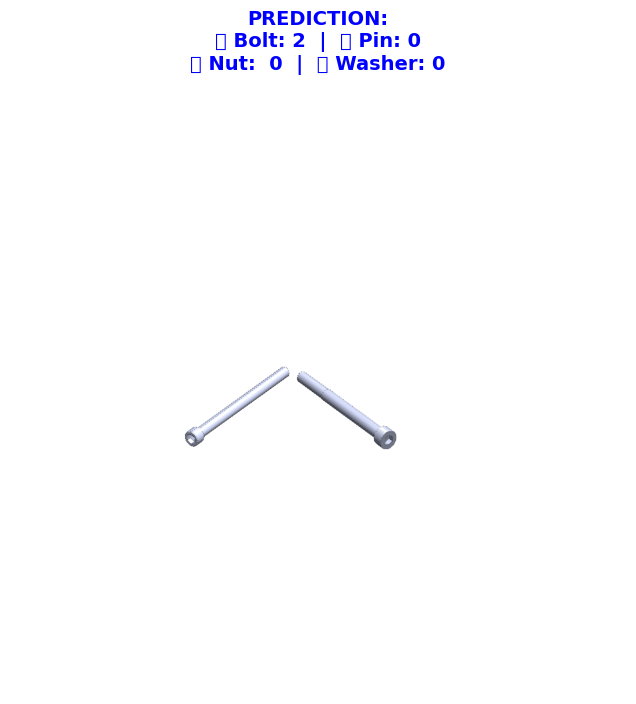

In [11]:
import cv2
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt


img_path = '/kaggle/working/train_synthetic/synth_00004.png'


transform = A.Compose([
    A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])


image = cv2.imread(img_path)
if image is None:
    print(f"❌ Error: Image not found at {img_path}")
else:

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    

    transformed = transform(image=image_rgb)['image']
    input_tensor = transformed.unsqueeze(0).to(Config.DEVICE)


    model.eval()
    with torch.no_grad():

        pred_1 = model(input_tensor)
        pred_2 = model(torch.flip(input_tensor, [3]))
        pred_3 = model(torch.flip(input_tensor, [2]))
        
        # Average & Round
        avg_pred = (pred_1 + pred_2 + pred_3) / 3.0
        final_counts = np.round(avg_pred.cpu().numpy()[0]).astype(int)
        final_counts = np.clip(final_counts, 0, None)


    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    
    result_text = (
        f"PREDICTION:\n"
        f"🔩 Bolt: {final_counts[0]}  |  📍 Pin: {final_counts[1]}\n"
        f"🔩 Nut:  {final_counts[2]}  |  ⭕ Washer: {final_counts[3]}"
    )
    plt.title(result_text, fontsize=14, fontweight='bold', color='blue')
    plt.show()

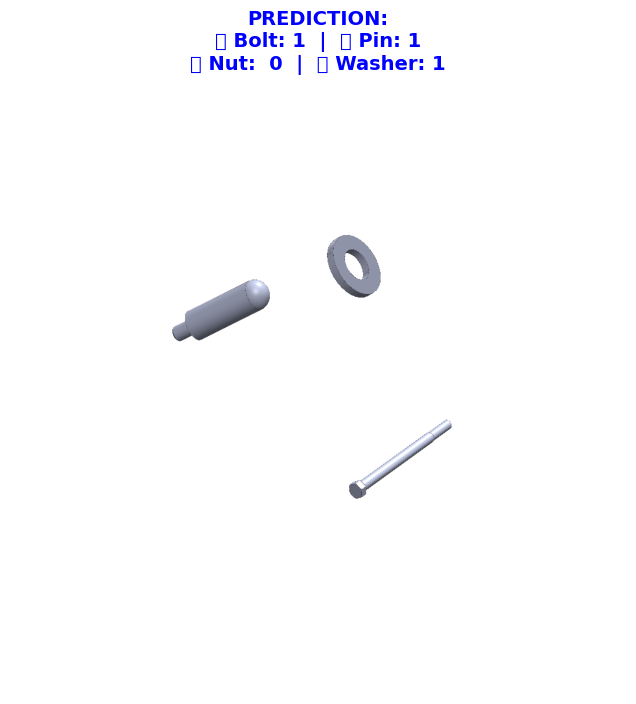

In [14]:
import cv2
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt


img_path = '/kaggle/working/train_synthetic/synth_00006.png'


transform = A.Compose([
    A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])


image = cv2.imread(img_path)
if image is None:
    print(f"❌ Error: Image not found at {img_path}")
else:
 
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    transformed = transform(image=image_rgb)['image']
    input_tensor = transformed.unsqueeze(0).to(Config.DEVICE)


    model.eval()
    with torch.no_grad():
   
        pred_1 = model(input_tensor)
        pred_2 = model(torch.flip(input_tensor, [3]))
        pred_3 = model(torch.flip(input_tensor, [2]))
        

        avg_pred = (pred_1 + pred_2 + pred_3) / 3.0
        final_counts = np.round(avg_pred.cpu().numpy()[0]).astype(int)
        final_counts = np.clip(final_counts, 0, None)

    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    
    result_text = (
        f"PREDICTION:\n"
        f"🔩 Bolt: {final_counts[0]}  |  📍 Pin: {final_counts[1]}\n"
        f"🔩 Nut:  {final_counts[2]}  |  ⭕ Washer: {final_counts[3]}"
    )
    plt.title(result_text, fontsize=14, fontweight='bold', color='blue')
    plt.show()

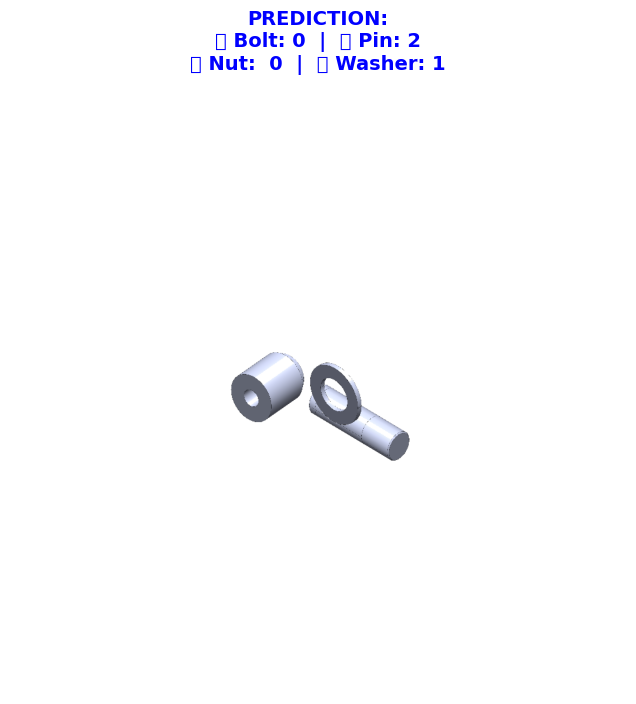

In [15]:
import cv2
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

img_path = '/kaggle/working/train_synthetic/synth_00008.png'


transform = A.Compose([
    A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])


image = cv2.imread(img_path)
if image is None:
    print(f"❌ Error: Image not found at {img_path}")
else:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    transformed = transform(image=image_rgb)['image']
    input_tensor = transformed.unsqueeze(0).to(Config.DEVICE)

    model.eval()
    with torch.no_grad():
        # A. Normal
        pred_1 = model(input_tensor)
        # B. Horizontal Flip
        pred_2 = model(torch.flip(input_tensor, [3]))
        # C. Vertical Flip
        pred_3 = model(torch.flip(input_tensor, [2]))
        
        # Average & Round
        avg_pred = (pred_1 + pred_2 + pred_3) / 3.0
        final_counts = np.round(avg_pred.cpu().numpy()[0]).astype(int)
        final_counts = np.clip(final_counts, 0, None)

    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    
    result_text = (
        f"PREDICTION:\n"
        f"🔩 Bolt: {final_counts[0]}  |  📍 Pin: {final_counts[1]}\n"
        f"🔩 Nut:  {final_counts[2]}  |  ⭕ Washer: {final_counts[3]}"
    )
    plt.title(result_text, fontsize=14, fontweight='bold', color='blue')
    plt.show()

🚀 Running Test Cases on top 100 images...
----------------------------------------
----------------------------------------
📊 TEST RESULTS (Top 100 Images)
✅ Passed: 96
❌ Failed: 4
🎯 Accuracy: 96.0%
----------------------------------------

🖼️ Displaying top 10 CORRECT images with >3 objects:


/tmp/ipykernel_47/364218946.py:103: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


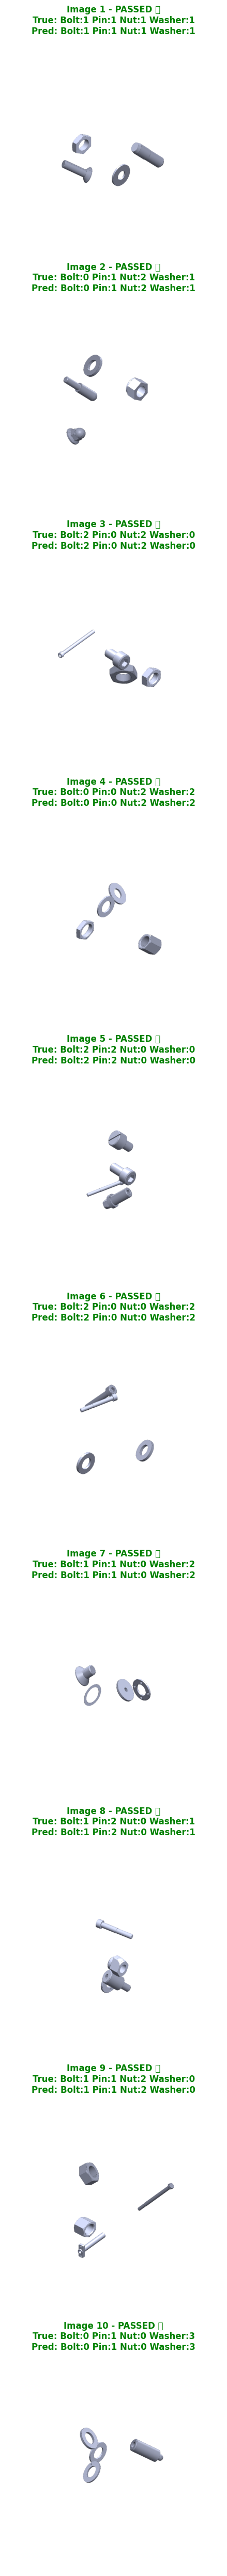

In [20]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2


SYNTH_IMG_DIR = '/kaggle/working/train_synthetic'
SYNTH_CSV = '/kaggle/working/synthetic_labels.csv'
CHECK_LIMIT = 100  


df = pd.read_csv(SYNTH_CSV).head(CHECK_LIMIT)

transform = A.Compose([
    A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Counters
passed_count = 0
failed_count = 0
correct_complex_cases = [] 

print(f"🚀 Running Test Cases on top {CHECK_LIMIT} images...")
print("-" * 40)

model.eval()

for index, row in df.iterrows():
    img_name = row['image_name']
    img_path = os.path.join(SYNTH_IMG_DIR, img_name)
    
    image = cv2.imread(img_path)
    if image is None:
        continue
        
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed = transform(image=image_rgb)['image']
    input_tensor = transformed.unsqueeze(0).to(Config.DEVICE)

    true_counts = [row['bolt'], row['locatingpin'], row['nut'], row['washer']]
    total_objects = sum(true_counts)

    with torch.no_grad():
        pred_1 = model(input_tensor)
        pred_2 = model(torch.flip(input_tensor, [3]))
        pred_3 = model(torch.flip(input_tensor, [2]))
        
        avg_pred = (pred_1 + pred_2 + pred_3) / 3.0
        pred_counts = np.round(avg_pred.cpu().numpy()[0]).astype(int)
        pred_counts = np.clip(pred_counts, 0, None).tolist() # Convert to list for comparison

    if pred_counts == true_counts:
        passed_count += 1
        if total_objects > 3:
            correct_complex_cases.append((image_rgb, true_counts, pred_counts))
    else:
        failed_count += 1

print("-" * 40)
print(f"📊 TEST RESULTS (Top {CHECK_LIMIT} Images)")
print(f"✅ Passed: {passed_count}")
print(f"❌ Failed: {failed_count}")
print(f"🎯 Accuracy: {(passed_count/CHECK_LIMIT)*100:.1f}%")
print("-" * 40)

print(f"\n🖼️ Displaying top {min(10, len(correct_complex_cases))} CORRECT images with >3 objects:")

if len(correct_complex_cases) > 0:
    num_display = min(10, len(correct_complex_cases))
    fig, axes = plt.subplots(num_display, 1, figsize=(8, 5 * num_display))
    
    if num_display == 1: axes = [axes]

    for i in range(num_display):
        img, true_v, pred_v = correct_complex_cases[i]
        
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(
            f"Image {i+1} - PASSED ✅\n"
            f"True: Bolt:{true_v[0]} Pin:{true_v[1]} Nut:{true_v[2]} Washer:{true_v[3]}\n"
            f"Pred: Bolt:{pred_v[0]} Pin:{pred_v[1]} Nut:{pred_v[2]} Washer:{pred_v[3]}",
            color='green', fontsize=12, fontweight='bold'
        )
    plt.tight_layout()
    plt.show()
else:
    print("No images found that were both CORRECT and had >3 objects.")

🚀 Running Test Cases on ALL 2000 images...
----------------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

----------------------------------------
📊 FINAL TEST RESULTS (All Images)
✅ Passed: 1874
❌ Failed: 126
🎯 Accuracy: 93.70%
----------------------------------------

🖼️ Displaying top 50 CORRECT images with >3 objects:


/tmp/ipykernel_47/2351259188.py:105: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


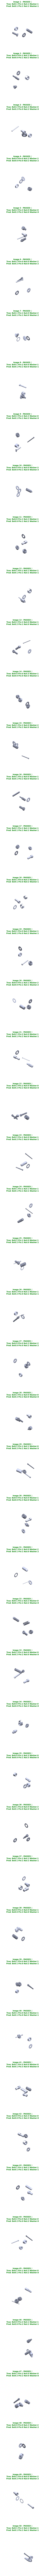

In [21]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm  # Added for progress bar

SYNTH_IMG_DIR = '/kaggle/working/train_synthetic'
SYNTH_CSV = '/kaggle/working/synthetic_labels.csv'
DISPLAY_LIMIT = 50 


df = pd.read_csv(SYNTH_CSV)
total_images = len(df)

# Define Transform
transform = A.Compose([
    A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Counters
passed_count = 0
failed_count = 0
correct_complex_cases = [] 

print(f"🚀 Running Test Cases on ALL {total_images} images...")
print("-" * 40)

model.eval()


for index, row in tqdm(df.iterrows(), total=total_images):
  
    img_name = row['image_name']
    img_path = os.path.join(SYNTH_IMG_DIR, img_name)
    
    image = cv2.imread(img_path)
    if image is None:
        continue
        
 
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed = transform(image=image_rgb)['image']
    input_tensor = transformed.unsqueeze(0).to(Config.DEVICE)


    true_counts = [row['bolt'], row['locatingpin'], row['nut'], row['washer']]
    total_objects = sum(true_counts)


    with torch.no_grad():
        pred_1 = model(input_tensor)
        pred_2 = model(torch.flip(input_tensor, [3]))
        pred_3 = model(torch.flip(input_tensor, [2]))
        
        avg_pred = (pred_1 + pred_2 + pred_3) / 3.0
        pred_counts = np.round(avg_pred.cpu().numpy()[0]).astype(int)
        pred_counts = np.clip(pred_counts, 0, None).tolist()


    if pred_counts == true_counts:
        passed_count += 1
        if total_objects > 3:
            correct_complex_cases.append((image_rgb, true_counts, pred_counts))
    else:
        failed_count += 1

print("-" * 40)
print(f"📊 FINAL TEST RESULTS (All Images)")
print(f"✅ Passed: {passed_count}")
print(f"❌ Failed: {failed_count}")
print(f"🎯 Accuracy: {(passed_count/total_images)*100:.2f}%")
print("-" * 40)

# --- DISPLAY CORRECT & COMPLEX IMAGES ---
num_display = min(DISPLAY_LIMIT, len(correct_complex_cases))
print(f"\n🖼️ Displaying top {num_display} CORRECT images with >3 objects:")

if num_display > 0:
    fig, axes = plt.subplots(num_display, 1, figsize=(8, 5 * num_display))
    
    if num_display == 1: axes = [axes] 

    for i in range(num_display):
        img, true_v, pred_v = correct_complex_cases[i]
        
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(
            f"Image {i+1} - PASSED ✅\n"
            f"True: Bolt:{true_v[0]} Pin:{true_v[1]} Nut:{true_v[2]} Washer:{true_v[3]}\n"
            f"Pred: Bolt:{pred_v[0]} Pin:{pred_v[1]} Nut:{pred_v[2]} Washer:{pred_v[3]}",
            color='green', fontsize=12, fontweight='bold'
        )
    plt.tight_layout()
    plt.show()
else:
    print("No complex cases found.")

In [22]:
import shutil
import os
from IPython.display import FileLink, display

print("📦 Zipping folder... this may take a minute...")
shutil.make_archive('train_synthetic', 'zip', '/kaggle/working/train_synthetic')
print("✅ Zipping complete!")

print("\n⬇️ Click these links to download:")
display(FileLink('train_synthetic.zip'))
display(FileLink('synthetic_labels.csv'))

📦 Zipping folder... this may take a minute...
✅ Zipping complete!

⬇️ Click these links to download:


/kaggle/working/train_synthetic.zip

/kaggle/working/synthetic_labels.csv